<a href="https://colab.research.google.com/github/marquesbmc/Artificial-Intelligence/blob/main/grid2d_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym
!pip install --upgrade ipython

# *Environment*

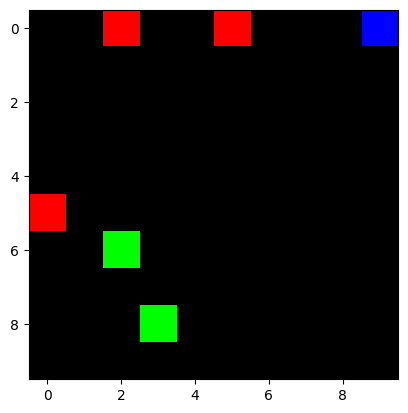

In [20]:
import numpy as np
import itertools
from skimage.transform import resize
import matplotlib.pyplot as plt
import gym
from gym import spaces

class Grid2DObject(object):
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

class Grid2DEnv(gym.Env):
    def __init__(self, partial=True, sizeX=10, sizeY=10):
        super(Grid2DEnv, self).__init__()

        self.sizeX = sizeX
        self.sizeY = sizeY
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84, 3), dtype=np.uint8)
        self.channel = 3
        self.partial = partial
        self.radar = 7
        self.objects = []
        self.state_full = self.reset()

    def _newPosition(self, occupied_positions):
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        for pos in occupied_positions:
            if pos in points:
                points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]

    def reset(self):
        self.objects = []
        occupied_positions = []
        state_full = None
        rgb_channel = 3
        matrix_G = np.zeros([self.sizeX, self.sizeY, rgb_channel])
        num_goals = 2
        for _ in range(num_goals):
            goal_pos = self._newPosition(occupied_positions)
            goal_obj = Grid2DObject(goal_pos, 1, 1, 1, 1, 'goal')
            self.objects.append(goal_obj)
            occupied_positions.append(goal_pos)
        for _ in range(3):
            fire_pos = self._newPosition(occupied_positions)
            fire_obj = Grid2DObject(fire_pos, 1, 1, 0, -1, 'fire')
            self.objects.append(fire_obj)
            occupied_positions.append(fire_pos)
        agent_pos = self._newPosition(occupied_positions)
        agent = Grid2DObject(agent_pos, 1, 1, 2, None, 'agent')
        self.objects.append(agent)
        for item in self.objects:
            matrix_G[item.x, item.y, item.channel] = item.intensity * 255
        self.state_full = matrix_G
        return matrix_G

    def step(self, agent, action):
        penalty = self.moveChar(agent, action)
        reward, done = self.checkGoal(agent)
        state_full = self._render_full()
        state = self.render(agent)
        return state, (reward + penalty), done, {}

    def render(self, agent):
        if isinstance(agent, Grid2DObject):
            state = self._get_cut_around(self.state_full, agent.x, agent.y, self.radar)
        else:
            state = None
        return state

    def _search_agent(self):
        for o in env.objects:
            if o.name == 'agent':
                agent = o
                return agent
        return None

    def close(self):
        pass

    def moveChar(self, agent, direction):
        agentX = agent.x
        agentY = agent.y
        penalize = 0.0
        nextX, nextY = agent.x, agent.y
        if direction == 0 and agent.y >= 1:
            nextY -= 1
        elif direction == 1 and agent.y <= self.sizeY - 2:
            nextY += 1
        elif direction == 2 and agent.x >= 1:
            nextX -= 1
        elif direction == 3 and agent.x <= self.sizeX - 2:
            nextX += 1
        if nextX < 0 or nextX >= self.sizeX or nextY < 0 or nextY >= self.sizeY:
            penalize += -0.1
            nextX, nextY = agent.x, agent.y
        elif any(obj.name == 'goal' and obj.x == nextX and obj.y == nextY for obj in self.objects):
            penalize += -0.1
            nextX, nextY = agent.x, agent.y
        elif any(obj.name == 'fire' and obj.x == nextX and obj.y == nextY for obj in self.objects):
            penalize += -0.1
            nextX, nextY = agent.x, agent.y
        agent.x, agent.y = nextX, nextY
        return penalize

    def checkGoal(self, agent):
        goals = [obj for obj in self.objects if obj.name == 'goal']
        for goal in goals:
            if abs(agent.x - goal.x) <= 1 and abs(agent.y - goal.y) <= 1:
                return 1.0, True
        fires = [obj for obj in self.objects if obj.name == 'fire']
        for fire in fires:
            if abs(agent.x - fire.x) <= 1 and abs(agent.y - fire.y) <= 1:
                return -1.0, False
        return 0.0, False

    def _render_full(self):
        matrix_G = np.zeros([self.sizeX, self.sizeY, self.channel])
        for item in self.objects:
            matrix_G[item.x, item.y, item.channel] = item.intensity * 255
        self.state_full = matrix_G
        return matrix_G

    def _get_cut_around(self, matrix, lin, col, length):
        n, m, channels = len(matrix), len(matrix[0]), len(matrix[0][0])
        matrix_cut = [[[0 for k in range(channels)] for j in range(length)] for i in range(length)]
        offset = length // 2
        for i in range(-offset, offset + 1):
            for j in range(-offset, offset + 1):
                for k in range(channels):
                    if 0 <= lin + i < n and 0 <= col + j < m:
                        matrix_cut[i + offset][j + offset][k] = matrix[lin + i][col + j][k]
                    else:
                        matrix_cut[i + offset][j + offset][k] = 1 * 255
        return matrix_cut

env = Grid2DEnv(partial = True, sizeX=10, sizeY=10)
state_full = env.reset()

def plot(state):
    if isinstance(state, list):
        state = np.array(state)
    if state.dtype == np.float32:
        state = np.clip(state, 0, 1)
    else:
        state = np.clip(state, 0, 255).astype(np.uint8)
    plt.imshow(state)
    return plt.show()

plot(state_full)

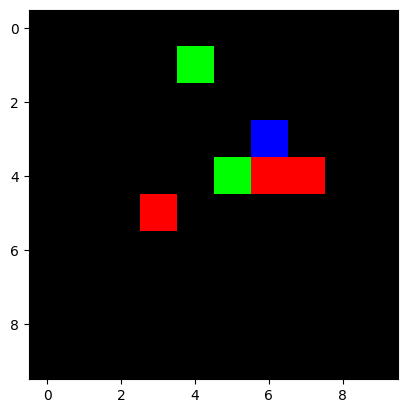

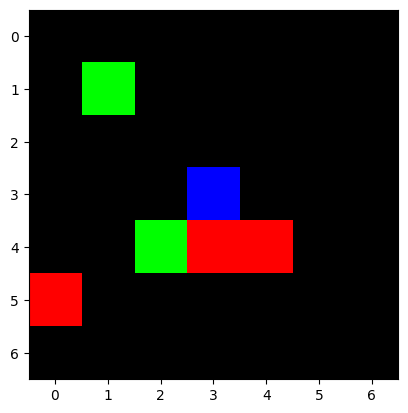

0.0


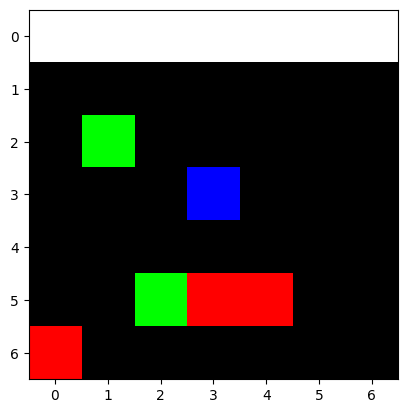

0.0


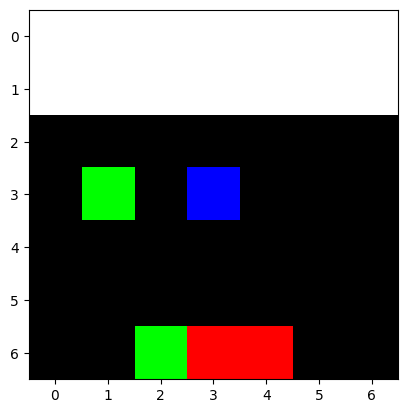

0.0


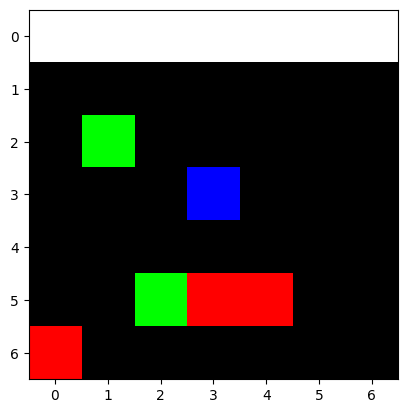

0.0


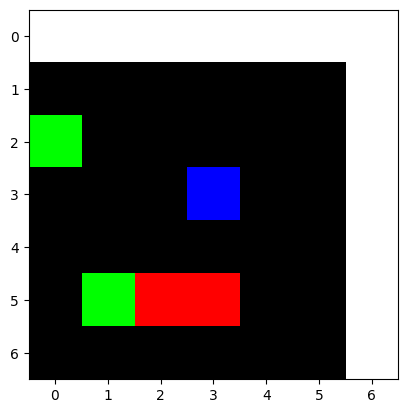

-1.0


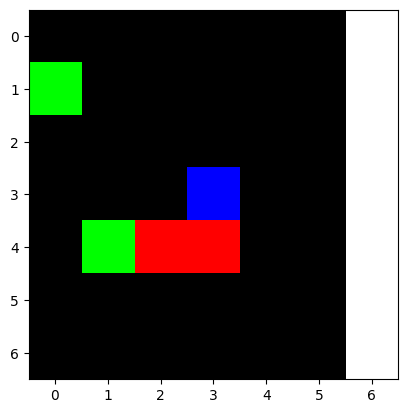

-1.1


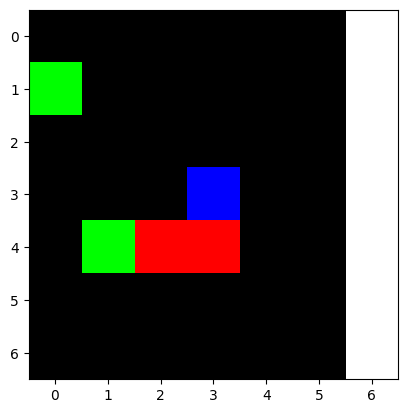

-1.1


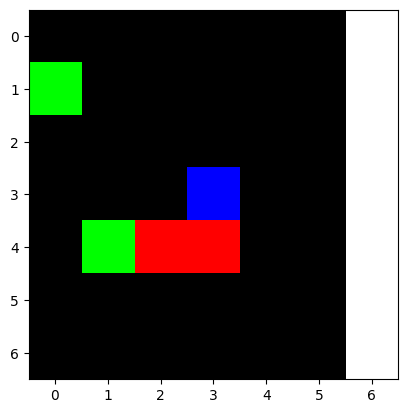

-1.1


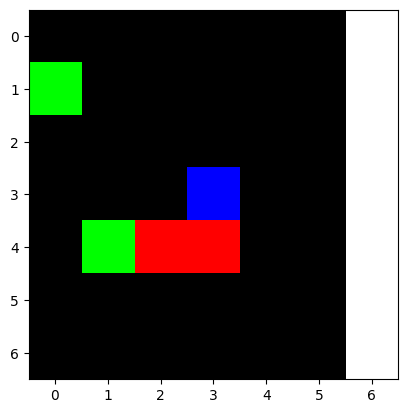

0.0


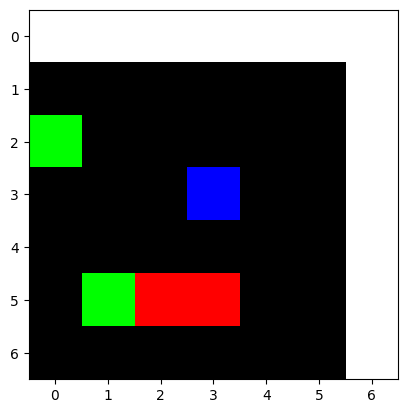

0.0


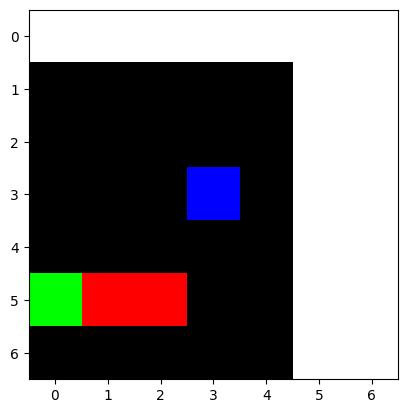

0.0


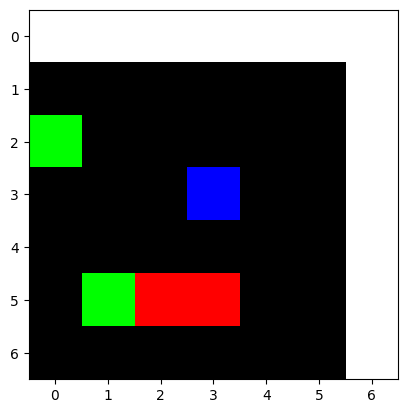

0.0


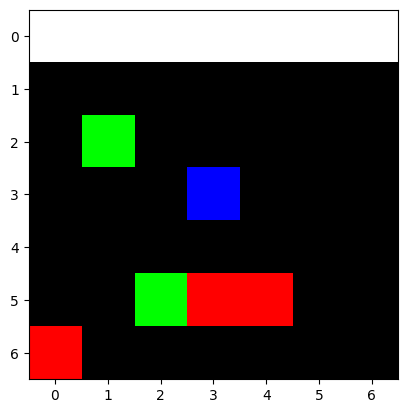

1.0
Episode 1 finished with total reward: -3.3000000000000007


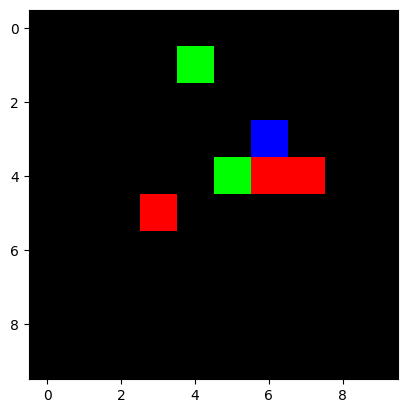

In [21]:
if __name__ == "__main__":
    # Crie uma instância do ambiente
    env = Grid2DEnv(sizeX=10, sizeY=10)  # Defina partial=True para visão parcial
    env = Grid2DEnv(partial = True, sizeX=10, sizeY=10)
    state_clipped = np.clip(env.reset(), 0, 255)
    plt.imshow(state_clipped, interpolation="nearest")

    # Número de episódios para testar
    num_episodes = 1

    for episode in range(num_episodes):
        state_full = env.reset()
        plot(state_full)
        done = False
        total_reward = 0

        while not done:
            # Procura agent
            agent = env._search_agent()

            # Informa status parcial do agent apartir de uma agente e um state full do env
            state = env.render(agent)
            plot(state)

            # Escolha uma ação aleatória
            action = env.action_space.sample()


            # Execute a ação no ambiente
            next_state, reward, done, _ = env.step(agent, action)
            print(reward)
            total_reward += reward


        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    plot(env.state_full)
    env.close()


# *Deep Learning*

In [15]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Concatenate, Conv2D, Flatten, TimeDistributed, Lambda
import keras.backend as K
from keras.utils import to_categorical

class Qnetwork():
    def __init__(self, num_channels, timesteps, height, width, id_dim):
        self.num_channels = num_channels
        self.timesteps = timesteps
        self.height = height
        self.width = width
        self.id_dim = id_dim
        self.build_model()

    def build_model(self):
        # Definição das dimensões de entrada
        input_shape = (self.timesteps, self.height, self.width, self.num_channels)

        # Entradas
        observation_input = Input(shape=input_shape, name="observation_input")
        agent_id_input = Input(shape=(self.id_dim,), name="agent_id_input")

        # Camada Linear para ID
        id_embedding = Dense(128, activation="relu")(agent_id_input)

        # Camadas Convolucionais para a Observação
        conv1 = TimeDistributed(Conv2D(32, (3, 3), activation="relu"))(observation_input)
        conv2 = TimeDistributed(Conv2D(64, (3, 3), activation="relu"))(conv1)
        flattened = TimeDistributed(Flatten())(conv2)

        # Concatenação da Observação e ID
        # Repetindo a ID incorporada para cada timestep
        id_embedding_repeated = Lambda(lambda x: K.repeat(x, self.timesteps))(id_embedding)
        concatenated = Concatenate(axis=-1)([flattened, id_embedding_repeated])

        # LSTM
        lstm_out = GRU(128)(concatenated)

        # Camada de Saída (por simplicidade, vamos assumir 4 ações possíveis: cima, baixo, esquerda, direita)
        output = Dense(4, activation="softmax")(lstm_out)

        # Modelo
        self.model = Model(inputs=[observation_input, agent_id_input], outputs=output)
        self.model.compile(optimizer="adam", loss="categorical_crossentropy")

    def summary(self):
        self.model.summary()

# Exemplo de uso:
num_channels = 3
timesteps = 10
height, width = 7, 7
id_dim = 1

model = Qnetwork(num_channels, timesteps, height, width, id_dim)
model.summary()

In [22]:
import numpy as np
import itertools
from skimage.transform import resize
import matplotlib.pyplot as plt
import gym
from gym import spaces

# Defina a classe Qnetwork aqui

# Defina a função para preprocessar observações
def preprocess_observation(observation):
    # Redimensione a observação para o tamanho esperado pela Qnetwork
    # Certifique-se de que a forma seja compatível com a da Qnetwork
    return resize(observation, (7, 7, 3), anti_aliasing=True).astype(np.uint8)

# Crie uma instância do ambiente Grid2DEnv
env = Grid2DEnv(sizeX=7, sizeY=7)

# Inicialize a Qnetwork com os parâmetros adequados
num_channels = 3  # O número de canais na observação do ambiente Grid2DEnv é 3
timesteps = 1  # Não estamos tratando de uma sequência temporal aqui, então timesteps = 1
height, width = 7, 7  # Redimensione a observação para 84x84
id_dim = 1  # Não estamos usando uma ID do agente neste ambiente

# Crie uma instância da Qnetwork
q_network = Qnetwork(num_channels, timesteps, height, width, id_dim)

# Defina alguns hiperparâmetros para treinamento
batch_size = 32
num_episodes = 1000
epsilon = 0.1  # Taxa de exploração

# Treine a Qnetwork
for episode in range(num_episodes):
    observation = env.reset()
    print(observation)
    done = False
    total_reward = 0

    while not done:
        # Pré-processamento da observação
        preprocessed_observation = preprocess_observation(observation)

        # Escolha uma ação usando a política epsilon-greedy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Ação aleatória (exploração)
        else:
            # Exploitação: escolha a ação com o maior valor Q
            q_values = q_network.model.predict([np.expand_dims(preprocessed_observation, axis=0)])
            action = np.argmax(q_values)

        # Execute a ação no ambiente
        next_observation, reward, done, _ = env.step(action)

        # Atualize a Qnetwork com a experiência
        # (implementação do treinamento da Qnetwork aqui)

        total_reward += reward
        observation = next_observation

    print(f"Episódio {episode + 1}: recompensa total = {total_reward}")

# Salve o modelo após o treinamento
q_network.model.save("modelo_treinado.h5")


NameError: ignored

In [ ]:
def rgb_to_gray(rgb_image):
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])

In [ ]:
import cv2

def resize(image, width, height):
    return cv2.resize(image, (width, height), interpolation = cv2.INTER_LINEAR)

In [ ]:
def crop(image, top, bottom, left, right):
    return image[top:bottom, left:right]

In [ ]:
def normalize(image):
    return image / 255.0

In [ ]:
def preprocess(image, width, height, top, bottom, left, right):
    grayscale = rgb_to_gray(image)
    cropped = crop(grayscale, top, bottom, left, right)
    resized = resize(cropped, width, height)
    return normalize(resized)